# Diffusion

In [2]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [6]:
#| export
import torchvision.transforms.v2 as transforms

from nimrod.models.diffusion import DiffusorX
from nimrod.models.core import lr_finder, train_one_cycle

from omegaconf import OmegaConf

from hydra.utils import instantiate

## Data

In [4]:
BATCH_SIZE = 512

cfg = OmegaConf.load('../config/data/image/mnist.yaml')
tfs = transforms.Compose([transforms.ToTensor(), transforms.Resize(32), transforms.Normalize((0.5,), (0.5,))])  
dm = instantiate(cfg, batch_size=BATCH_SIZE, transforms=tfs, num_workers=0)
dm.prepare_data()
dm.setup()

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
[20:25:50] INFO - Init ImageDataModule for mnist
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'transforms' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['transforms'])`.
[20:25:55] INFO - loading dataset mnist with args () from split train
[20:25:55] INFO - loading dataset mnist from split train
Overwrite dataset info from restored data version if exists.
[20:25:58] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ..

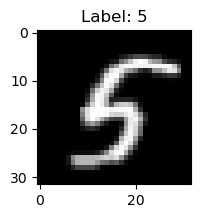

In [ ]:
dm.dim
dm.show(0)

## Training

In [ ]:

optimizer = partial(torch.optim.AdamW, lr=3e-4)

nnet = UNet2DModel(
    sample_size=H,
    in_channels=C,
    out_channels=C,
    block_out_channels=(32, 64, 128, 256)
    )

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
)


print(f"steps: {noise_scheduler.config.num_train_timesteps}")
model = DiffusorX(nnet, noise_scheduler, optimizer)
x = torch.randn((B, C, H, W))

t = torch.randint(0, noise_scheduler.config.num_train_timesteps, (B,))
print(f"x:{x.shape}, t: {t.shape}, {type(t)}")
noise = nnet(x, t).sample
print(noise.shape)
print(model(x, 

In [7]:
# SETUP
project_name = "MNIST-Diffusion"

N_EPOCHS = 5
do_lr_finder = False
exp_logger = 'wandb'
precision = "16-mixed" # 16-mixed, 32-true

block_out_channels = [32, 64, 128, 256]  # channel/feature expansion


cfg = OmegaConf.load('../config/model/image/diffusorx.yaml')
cfg.nnet.block_out_channels = block_out_channels  # channel/feature expansion
model = instantiate(cfg) #partial

tags = [
    f"precision:{precision}",
    f"block_chan:{block_out_channels}",
    f"bs:{dm.batch_size}",
    f"epochs:{N_EPOCHS}"
    ]

# LR Finder
if do_lr_finder:
    suggested_lr = lr_finder(model, dm, plot=True)
    print(f"Suggested learning rate: {suggested_lr}")
else:
    suggested_lr = 3e-4

# ONE-CYCLE TRAINING
trained_model, best_ckpt_path = train_one_cycle(
    model,
    dm,
    n_epochs=N_EPOCHS,
    max_lr=suggested_lr,
    project_name=project_name,
    tags=tags,
    model_summary=False,
    logger_cb=exp_logger,
    precision=precision
    )

Using 16bit Automatic Mixed Precision (AMP)
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[20:26:59] INFO - Regressor: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.
[20:26:59] INFO - DiffusionX: init
wandb: Currently logged in as: slegroux. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


[20:27:03] INFO - Regressor: configure_optimizers
[20:27:03] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[20:27:03] INFO - Scheduler: <class 'torch.optim.lr_scheduler.OneCycleLR'>

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | nnet         | UNet2DModel      | 15.9 M | train
1 | criterion    | MSELoss          | 0      | train
2 | train_mse    | MeanSquaredError | 0      | train
3 | val_mse      | MeanSquaredError | 0      | train
4 | test_mse     | MeanSquaredError | 0      | train
5 | val_mse_best | MinMetric        | 0      | train
6 | train_loss   | MeanMetric       | 0      | train
7 | val_loss     | MeanMetric       | 0      | train
8 | test_loss    | MeanMetric       | 0      | train
----------------------------------------------------------
15.9 M    Trainable params
0         Non-trainable params
15.9 M    Total params
63.563    Total estimated model params size (MB)
360       Modules in train mode
0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined